## installing projects

needed only once


In [0]:
#!git clone https://github.com/JelleAalbers/flamedisx.git
## Install flamedisx
#%cd flamedisx
#!git checkout master
#!git pull origin master
#!python setup.py develop
#%cd ..

In [0]:
#!pip install -U tensorflow-gpu==2.0.0-rc0
#!pip install -U tensorflow_probability==0.8.0-rc0

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import flamedisx as fd
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading data

csv file was previously prepared by straxen

In [4]:
df = pd.DataFrame.from_csv("./data_ar37.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


#### WARNING!!! VERY HACKY, don't do this in real life!
### changing some of the variables, whcih are not available 


In [0]:
df['s1'] = df['s1_area']
df['s2'] = df['s2_area']
df['x_observed'] = df['x_s2']
df['y_observed'] = df['y_s2']

df = df[(df['z'] < -20.0) & (df['z'] > -90.0) & (df['r'] < 40.0)]
df = df[(df['cs1'] < 5e2 ) & (df['cs1'] > 2e2)]
df = df[(df['cs2'] > 1e4 ) & (df['cs2'] < 5e4)]

## Writing my Krypton 83 source generator


In [0]:
o = tf.newaxis
class Kr83Source(fd.x1t_sr1.SR1ERSource):
  
  @staticmethod
  def energy_spectrum(drift_time):
    """Return (energies in keV, rate at these energies),
        both (n_events, n_energies) tensors.
    """
    # TODO: doesn't depend on drift_time...
    n_evts = drift_time.shape[0]
    return (fd.repeat(tf.cast(tf.linspace(42.45, 42.55, 2)[o, :],
                              dtype=fd.float_type()),
                      n_evts, axis=0),
            fd.repeat(tf.ones(2, dtype=fd.float_type())[o, :],
                      n_evts, axis=0))


  @staticmethod
  def s1_acceptance(s1):
      return tf.where((s1 < 0) | (s1 > 600),
                      tf.zeros_like(s1, dtype=fd.float_type()),
                      tf.ones_like(s1, dtype=fd.float_type()))

  @staticmethod
  def s2_acceptance(s2):
      return tf.where((s2 < 3000) | (s2 > 30000),
                      tf.zeros_like(s2, dtype=fd.float_type()),
                      tf.ones_like(s2, dtype=fd.float_type())) 

  @staticmethod
  def photon_detection_eff(s1_relative_ly, g1 =0.1426): 
      #g1 = 0.142 from paper
      mean_eff= g1 / (1. + 0.219)
      return mean_eff * s1_relative_ly

  @staticmethod
  def electron_detection_eff(drift_time, *, elife=700e3, extraction_eff=0.96):
      #TODO: include function for elife time dependency
      return extraction_eff * tf.exp(-drift_time / elife)

### creating my new source 

In [0]:
source = Kr83Source( data = df) 

### Producing simulations

In [0]:
dfsim = source.simulate(10000,data = df, **dict(g2=11.55/(1 - 0.64)*0.96 ) )

### Let's plot drift time vs s2 and check the electron livetime

Text(0, 0.5, 's2')

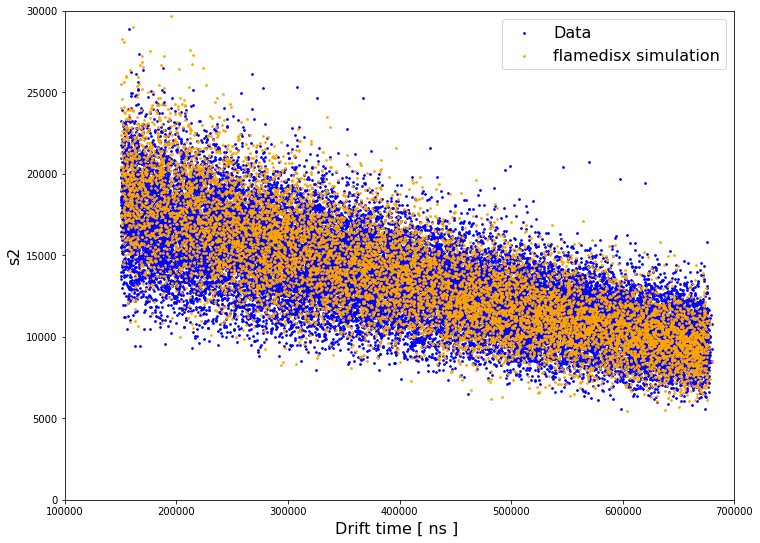

In [10]:
plt.figure(figsize=(12,9))

plt.scatter( df['drift_time'], df['s2'], s= 3, c="b", label = "Data")
plt.scatter( dfsim['drift_time'], dfsim['s2'], s= 3, c= "orange", label = "flamedisx simulation")
plt.xlim(1e5, 7e5);plt.ylim(0, 30000);
plt.legend(fontsize=16)
plt.xlabel("Drift time [ ns ] ", fontsize = 16)
plt.ylabel("s2", fontsize = 16)

Text(0.78, 0.93, 'Data (SR2)')

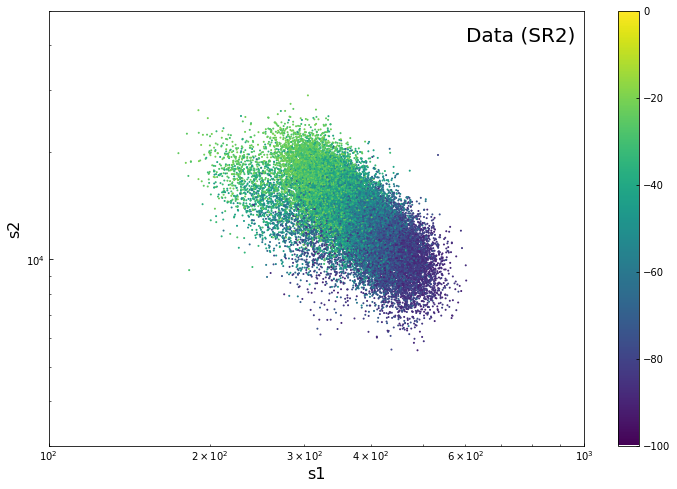

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
fig = plt.figure(figsize=(12,8), facecolor="w")
ax = fig.add_subplot(111)
plt.scatter(df['s1'],
            df['s2'], s=1, c = df['z'],
            vmin = -100, vmax = 0)
plt.xlim(1e2,1e3)
plt.ylim(3e3,5e4)

plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("s1", fontsize = 16)
plt.ylabel("s2", fontsize = 16)
plt.text(0.78, 0.93, "Data (SR2)", transform = ax.transAxes , fontsize = 20)

Text(0.78, 0.93, 'flamedisx sim')

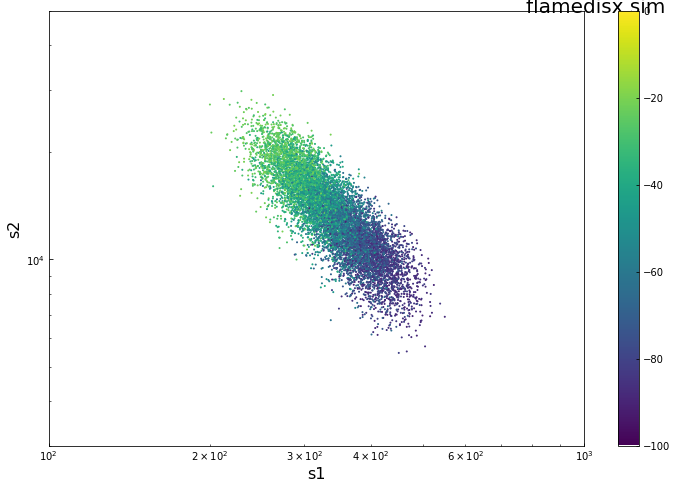

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.figure(figsize=(12,8), facecolor="w")
plt.scatter(dfsim['s1'],
            dfsim['s2'], s=1, c = dfsim['z'],
            vmin = -100, vmax = 0)
plt.xlim(1e2,1e3)
plt.ylim(3e3,5e4)

plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("s1", fontsize = 16)
plt.ylabel("s2", fontsize = 16)
plt.text(0.78, 0.93, "flamedisx sim", transform = ax.transAxes , fontsize = 20)